In [1]:
import sys
sys.path.append("/home/roozbeh/Morphology/McNeuron")
import McNeuron
import numpy as np
import pandas as pd
#import Asy
import matplotlib.pyplot as plt
from copy import deepcopy
from numpy.linalg import inv
from collections import Counter
import pickle
from numpy import sqrt as sqrt
import operator
# from Asy import asymmetric as asy
# from Asy import synthetic_data as syn
# from Asy import extract_stat as ext
# from Asy import visualize as viz
# from Asy import Neuron as Neuron
# from Asy import model_fitting as fit
%matplotlib inline

In [2]:
#!/usr/bin/env python
from __future__ import print_function
import os,sys
 
path = '/home/roozbeh/Morphology/Sam/time-varying/'
 
if len(sys.argv) == 2:
    path = sys.argv[1]

names = [] 
files = os.listdir(path)
for name in files:
    if name[-8:-4]=='app2':
        names = names + [name]
names = np.sort(names)

In [469]:
import math
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise
    rotation about the given axis by theta radians.
    
    Credit: https://stackoverflow.com/questions/6802577/
    rotation-of-3d-vector

    """
    axis = np.asarray(axis)
    axis = axis/math.sqrt(np.dot(axis, axis))
    a = math.cos(theta/2.0)
    b, c, d = -axis*math.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]]) 
def neuron_patches(neuron,
            show_width=False,
            show_soma=False,
            line_width=1,
            line_width_scale=10,
            color=[1,0,0],
            color_line_width=1,
            color_range=['red', 'orange', 'gold', 'green', 'cyan',
              'blue', 'violet', 'gray', 'pink', 'brown', 'magenta'],
            node_index_red_after=-1,
            show_loop=[],
            red_index=np.array([]),
            node_color=[],
            shift=(0, 0),
            scale=(1, 1),
            save=[],
            pass_ax=False,
            axis=[1,0,0],
            rotation=0,
            format_save='eps',
            ax='',
            title =''):
    

    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import matplotlib.cm as cm
    import matplotlib.animation as animation
    import pylab as pl
    from numpy.linalg import inv
    import matplotlib
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection
    import itertools

    from copy import deepcopy
    import matplotlib.colors as mcolors
    if isinstance(neuron, np.ndarray):
        location = neuron[:,2:5].T
        widths= neuron[:,5]
        parent_index = neuron[:,6] -1
        parent_index[0] = 0
        n_node = neuron.shape[0]
        n_soma = len(np.where(neuron[:,1]==1)[0])
    else:
        location = deepcopy(neuron.location)
        widths= neuron.diameter
        parent_index = neuron.parent_index
        n_node = neuron.n_node
        n_soma = neuron.n_soma

#     projection = rotation_matrix(axis=axis,
#                                  theta=rotation)
#     location = np.dot(projection, location)
#     location[0, :] = location[0,:]-min(location[0,:])
#     location[1, :] = location[1,:]-min(location[1,:])
    
    colors = np.ones([3, n_node])
    colors[0,:] = color[0]* colors[0,:]
    colors[1,:] = color[1]* colors[1,:]
    colors[2,:] = color[2]* colors[2,:]

    lines = []
    patches = []
    
    # Adding width
    linewidths = line_width*np.ones(n_node)
    if show_width:
        linewidths = widths*linewidths

    # Making red after a node
    
    if node_index_red_after >=0:
        ancestors = []
        par = node_index_red_after
        colors[:, par] = color
        linewidths[par] = line_width_scale*line_width
        ancestors.append(par)
        while par!=0:
            par = neuron.parent_index[par]
            ancestors.append(par)
            colors[:, par] = color
            linewidths[par] = line_width_scale*line_width
        red_index = np.array(ancestors)
    if len(show_loop) <10:
        color_range = list(mcolors.TABLEAU_COLORS.keys())
    else:
        color_range = list(mcolors.TABLEAU_COLORS.keys()) + \
        list(mcolors.CSS4_COLORS.keys())
    if len(show_loop) >0:
        
        for i in range(len(show_loop)):
            anc1 = get_ancestors(neuron.parent_index, show_loop[i][0])
            anc2 = get_ancestors(neuron.parent_index, show_loop[i][1])
            red_index = np.array(list(set(anc1)^set(anc2))).astype(int)
            for j in red_index:
                colors[j] = color_range[i]
                linewidths[j] = color_line_width
    # Making line for each edge
    for i in range(n_node):
        j = int(parent_index[i])
        lines.append([(location[0,i] + shift[0],
                       location[1,i] + shift[1]),
                      (location[0,j] + shift[0],
                       location[1,j] + shift[1])])
    if len(node_color) > 0:
        colors = node_color
    max_x = max(location[0,:])
    min_x = min(location[0,:])
    max_y = max(location[1,:])
    min_y = min(location[1,:])
    return lines, linewidths, colors, max_x, max_y, min_x, min_y


def add_patches(neurons_patches):
    n = len(neurons_patches)
    lines, linewidths, colors, max_x, max_y, min_x, min_y = neurons_patches[0]
    for i in range(1, n):
        lines_s, linewidths_s, colors_s, max_x_s, max_y_s, min_x_s, min_y_s = neurons_patches[i]
        lines = lines + lines_s
        linewidths = np.append(linewidths, linewidths_s)
        colors = np.append(colors,  colors_s, 1) 
        max_x = max(max_x, max_x_s)
        max_y = max(max_y, max_y_s) 
        min_x = min(min_x, min_x_s)
        min_y = min(min_y, min_y_s) 
    return lines, linewidths, colors.transpose(), max_x, max_y, min_x, min_y


def show_patches(lines, linewidths, colors, max_x, max_y, min_x, min_y, alpha=1, save_name=[], image_scale=1):
    from matplotlib import collections as mc
    lc = mc.LineCollection(lines,
                           linewidths=linewidths,
                           color=colors,
                           alpha=alpha)

    fig, ax = plt.subplots(figsize=(image_scale*(max_x-min_x)/50 , image_scale*(max_y-min_y)/50))
    ax.add_collection(lc)
    plt.axis('off')
    border = 4

    ax.set_xlim((min_x-border, max_x+border))
    ax.set_ylim((min_y-border, max_y+border))
#     else:
#         ax.add_collection(lc)
#         ax.axis('off')
#         ax.set_xlim((-.01,max(location[0,:])+.01))
#         ax.set_ylim((-.01,max(location[1,:])+.01))      
#     if(len(save)!=0):
#         fig.set_size_inches(scale)
#         plt.title(title)
#         plt.savefig(save, format = format_save)
#         plt.close(fig)
#     if pass_ax is False:
    if len(save_name)>0:
        plt.savefig(save_name)
    else:
        plt.show()

def translate_neuron(neuron, v=[0,0,0]):
    from copy import deepcopy
    neuron1 = deepcopy(neuron)
    neuron1[:,1] = neuron1[:,1] - v[0]
    neuron1[:,2] = neuron1[:,2] - v[1]
    neuron1[:,3] = neuron1[:,3] - v[2]
    
    return neuron1

def soma_adj(neuron):
    from copy import deepcopy
    neuron1 = deepcopy(neuron)
    neuron1[:,1] = neuron1[:,1] - neuron1[0,1]
    neuron1[:,2] = neuron1[:,2] - neuron1[0,2]
    neuron1[:,3] = neuron1[:,3] - neuron1[0,3]
    return neuron1

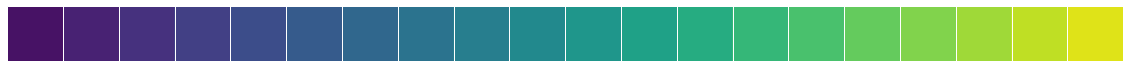

In [236]:
import seaborn as sns
sns.palplot(sns.color_palette("viridis", 20))

0
1
2
3
4
5
6
7
8
9
10


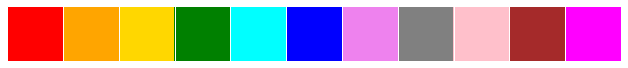

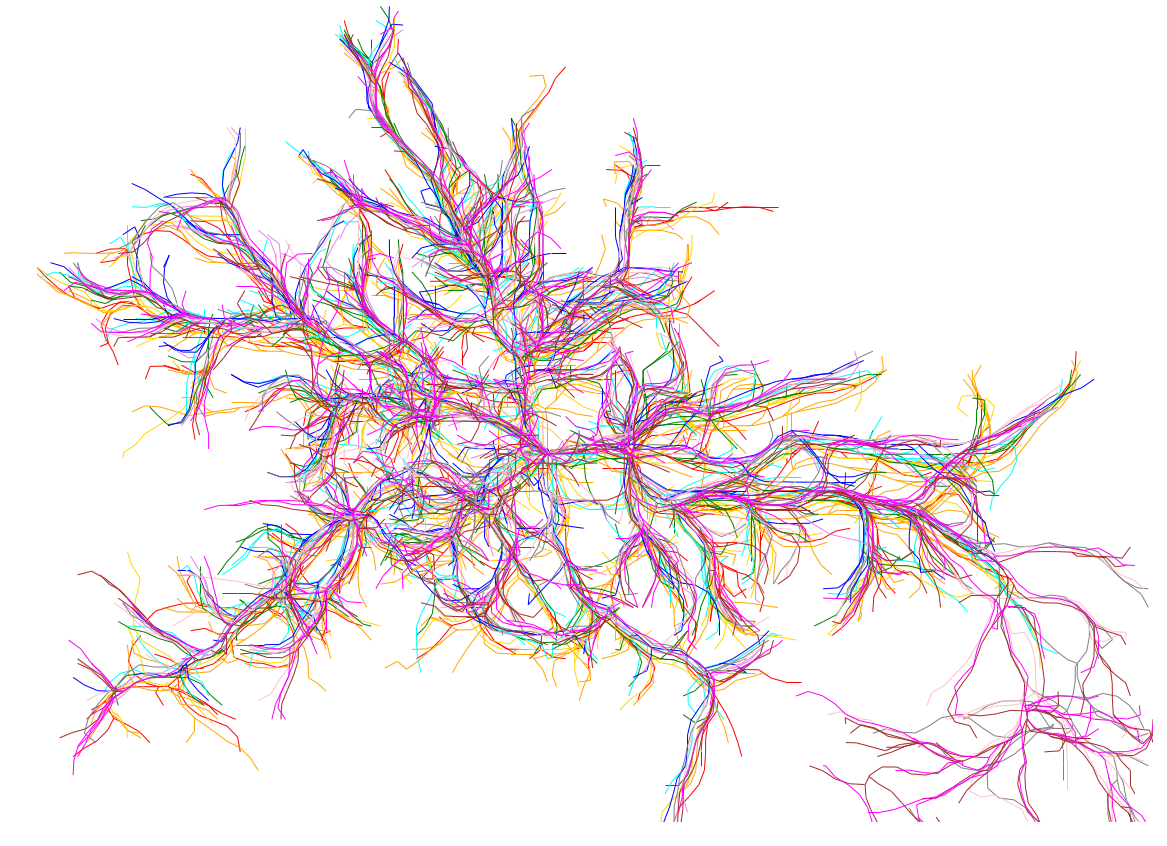

In [39]:
color_range=['red', 'orange', 'gold', 'green', 'cyan',
               'blue', 'violet', 'gray', 'pink', 'brown', 'magenta']
p = []
for i in range(0,11):
    neuron1 = soma_adj(np.loadtxt(path+names[2*i]))
    print(i)
    p1 = [neuron_patches(neuron1, color=color_range[i])]
    p = p + p1

lines, linewidths, colors, max_x, max_y, min_x, min_y = add_patches(p)
sns.palplot(color_range)
show_patches(lines, linewidths, colors, max_x, max_y, min_x, min_y)

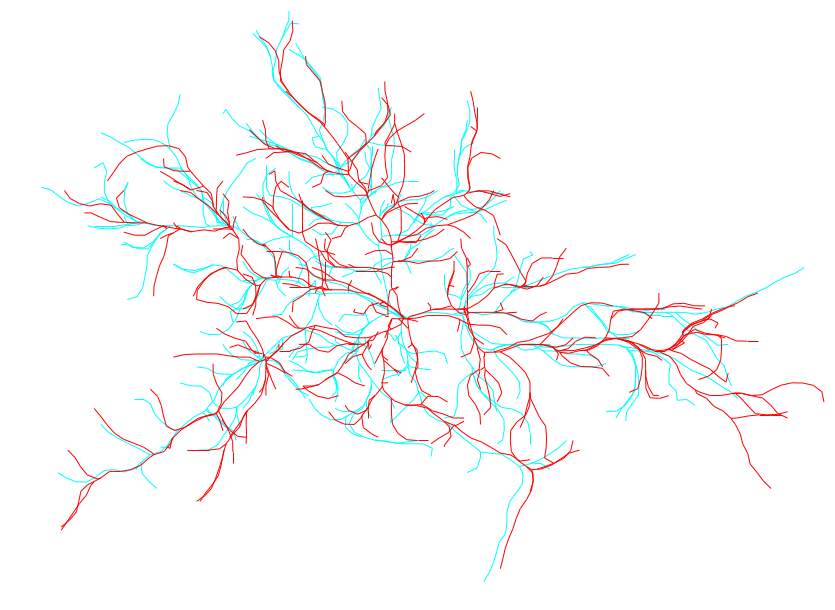

In [470]:
neuron1 = translate_neuron(np.loadtxt(path+names[15]), v=[274.   , 363.551, 397.488])
neuron1 = soma_adj(np.loadtxt(path+names[10]))
p1 = neuron_patches(neuron1, color=[0,1,1])

neuron2 = soma_adj(np.loadtxt(path+names[21]))
p2 = neuron_patches(neuron2)

neurons_patches = [p1, p2]
lines, linewidths, colors, max_x, max_y, min_x, min_y = add_patches(neurons_patches)
show_patches(lines, linewidths, colors, max_x, max_y, min_x, min_y)

In [105]:
neuron.get_swc().shape

(2261, 7)

In [ ]:
for i in range(0,len(names)):
    neuron = np.loadtxt(path+names[i])
    a = np.zeros([neuron.shape[0],3])
    a[:,0] =neuron[:,1]/280
    plot_2D(McNeuron.Neuron(neuron))#, node_color=a)

In [360]:
def get_trajectory(neuron, node_index):
    ancestors = []
    par = node_index
    ancestors.append(par)
    while par!=0:
        par = neuron.parent_index[par]
        ancestors.append(par)
    trajectory_index = np.flip(np.array(ancestors))
    swc_matrix = neuron.get_swc()[trajectory_index, :]
    swc_matrix[:, 6] = range(len(trajectory_index))
    swc_matrix[0, 6] = -1
    return swc_matrix

def get_arounding_node_index(neuron, arounding, radius):
    neuron.set_branch_order()
    end_points = np.where(neuron.features['branch order']==0)[0]
    arounding_end_points = \
    np.where(np.sqrt((neuron.location[0, end_points] - arounding[0])**2 + \
    (neuron.location[1, end_points] - arounding[1])**2 + \
    (neuron.location[2, end_points] - arounding[2])**2) < radius)[0]
    node_index = end_points[arounding_end_points]
    return node_index

# Plotting the end points

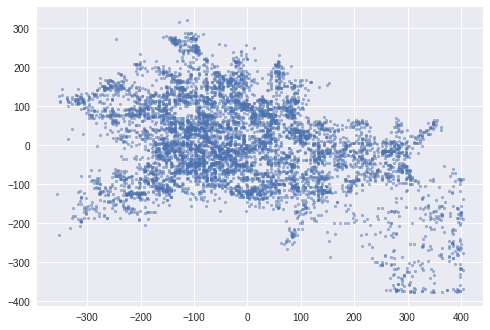

In [331]:
from sklearn.cluster import KMeans
locations = np.zeros([3,1])
for i in range(len(names)):
    neuron = McNeuron.Neuron(soma_adj(np.loadtxt(path+names[i])))
    neuron.set_branch_order()
    end_points = np.where(neuron.features['branch order']==0)[0]
    locations = np.append(locations, neuron.location[:, end_points], axis = 1)
plt.scatter(locations[0,:], locations[1,:], alpha=.5, s=8)

kmeans = KMeans(n_clusters=250)
kmeans = kmeans.fit(locations.transpose())
centroids = kmeans.cluster_centers_.transpose()

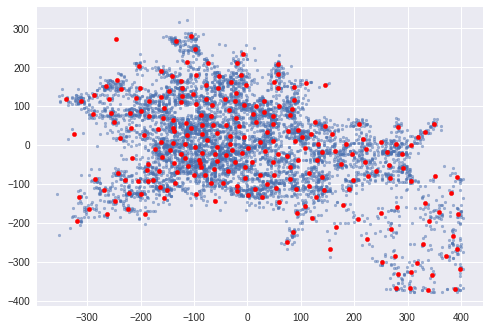

In [332]:
plt.scatter(locations[0,:], locations[1,:], alpha=.5, s=8)
plt.scatter(centroids[0,:], centroids[1,:], alpha=1, s=20, color='r')

In [435]:
centroids.shape

(3, 250)

In [ ]:
def plot_neurons_and_trajectories(patch_neurons, patch_trajectories, save_name=[], alpha=.1, image_scale=1):
    from matplotlib import collections as mc
    border = 4
    lines, linewidths, colors, max_x, max_y, min_x, min_y = patch_neurons
    lc1 = mc.LineCollection(lines,
                           linewidths=linewidths,
                           color=colors,
                           alpha=alpha)

    fig, ax = plt.subplots(nrows=2,
                           ncols=1, 
                           figsize=(image_scale*(max_x-min_x)/50 , image_scale*(max_y-min_y)/22))
    ax[0].add_collection(lc1)
    plt.axis('off')
    ax[0].set_xlim((min_x-border, max_x+border))
    ax[0].set_ylim((min_y-border, max_y+border))



    lines, linewidths, colors, max_x2, max_y2, min_x2, min_y2 = patch_trajectories
    lc2 = mc.LineCollection(lines,
                           linewidths=linewidths,
                           color=colors,
                           alpha=1)
    ax[1].add_collection(lc2)
    plt.axis('off')
    ax[1].set_xlim((min_x-border, max_x+border))
    ax[1].set_ylim((min_y-border, max_y+border))
    if len(save_name)>0:
        plt.savefig(save_name)
        plt.close(fig)
    else:
        plt.show()  

radius = 25
for n_i in range(250):
    arounding = centroids[:,n_i]
    patch_to_show = []
    for i in range(len(names)):
        neuron = McNeuron.Neuron(soma_adj(np.loadtxt(path+names[i])))
        node_index = get_arounding_node_index(neuron, arounding, radius=radius)
        if len(node_index)>0:
            patch_info = neuron_patches(neuron, node_index_red_after=node_index[0], 
                                        color=c[i, :],
                                       line_width_scale=8)
            patch_to_show.append(patch_info)
    patch_neurons = add_patches(patch_to_show)

    patch_to_show = []
    #arounding = centroids[:,n_i]
    for i in range(len(names)):
        neuron = McNeuron.Neuron(soma_adj(np.loadtxt(path+names[i])))
        node_index = get_arounding_node_index(neuron, arounding, radius=radius)
        if len(node_index)>0:
            swc_traj = soma_adj(get_trajectory(neuron, node_index[0]))
            trajectory = McNeuron.Neuron(swc_traj)
            patch_info = neuron_patches(trajectory, color=c[i, :], 
                                        node_index_red_after=swc_traj.shape[0]-1, line_width_scale=5)
            patch_to_show.append(patch_info)
    patch_trajectories = add_patches(patch_to_show)
    plot_neurons_and_trajectories(patch_neurons, patch_trajectories, save_name='trajectories/'+str(n_i)+'.jpg')

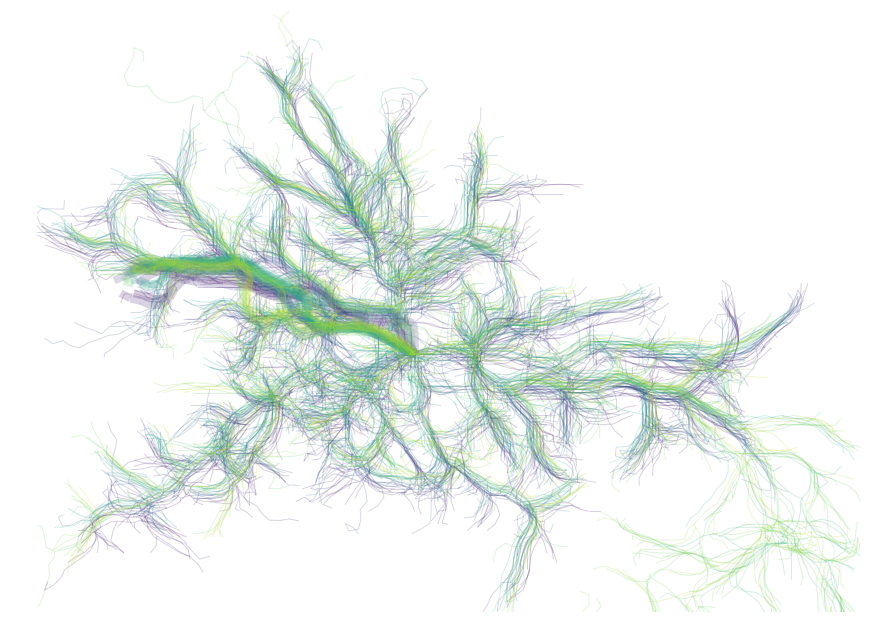

In [471]:
c = np.array(sns.color_palette("viridis", 23))
for j in range(1):
    radius = 25
    arounding = centroids[:,j+0]
    patch_to_show = []
    for i in range(len(names)):
        neuron = McNeuron.Neuron(soma_adj(np.loadtxt(path+names[i])))
        node_index = get_arounding_node_index(neuron, arounding, radius=radius)
        if len(node_index)>0:
            patch_info = neuron_patches(neuron, node_index_red_after=node_index[0], 
                                        color=c[i, :],
                                       line_width_scale=8)
            patch_to_show.append(patch_info)
    lines, linewidths, colors, max_x, max_y, min_x, min_y = add_patches(patch_to_show)

    show_patches(lines, linewidths, colors, max_x, max_y, min_x, min_y, alpha=.2, save_name=[])

In [483]:
centroids.shape

(3, 250)

In [486]:
dis = (centroids[0, :] - centroids[0, 0] )**2 +\
(centroids[1, :] - centroids[1, 0] )**2 + (centroids[2, :] - centroids[2, 0] )**2 
dis = np.where(dis<50**2)[0]

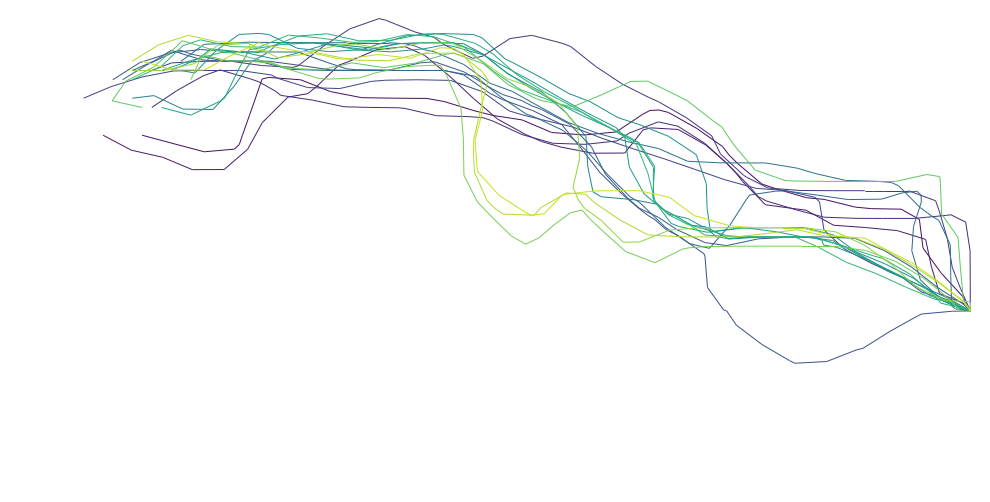

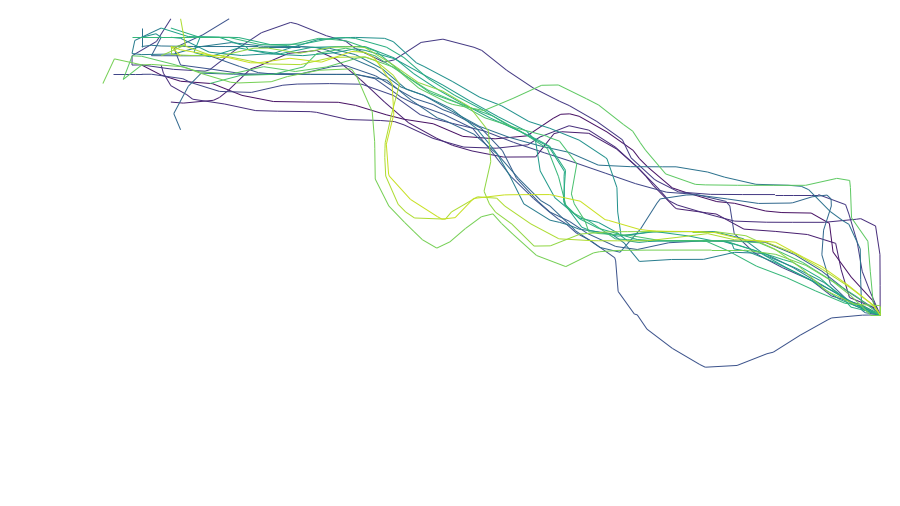

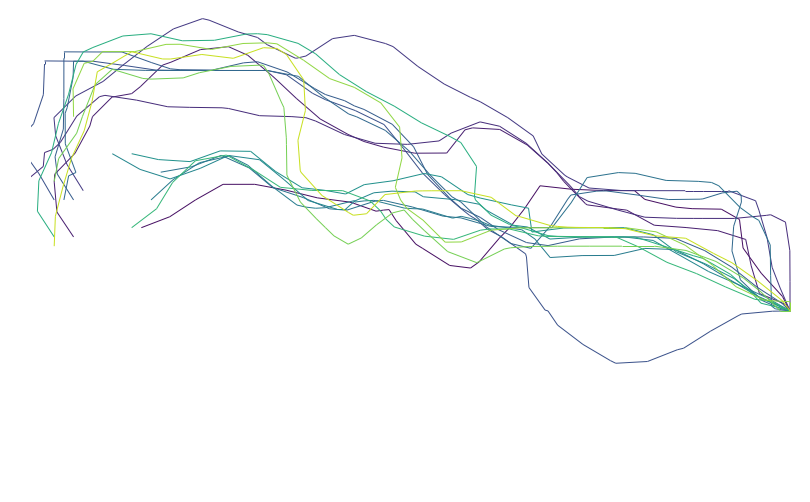

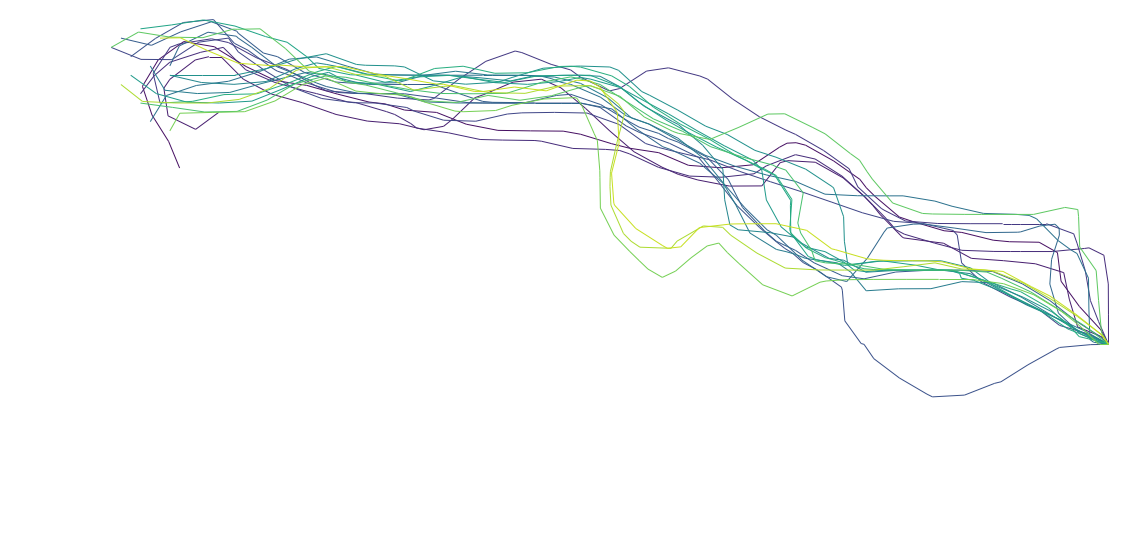

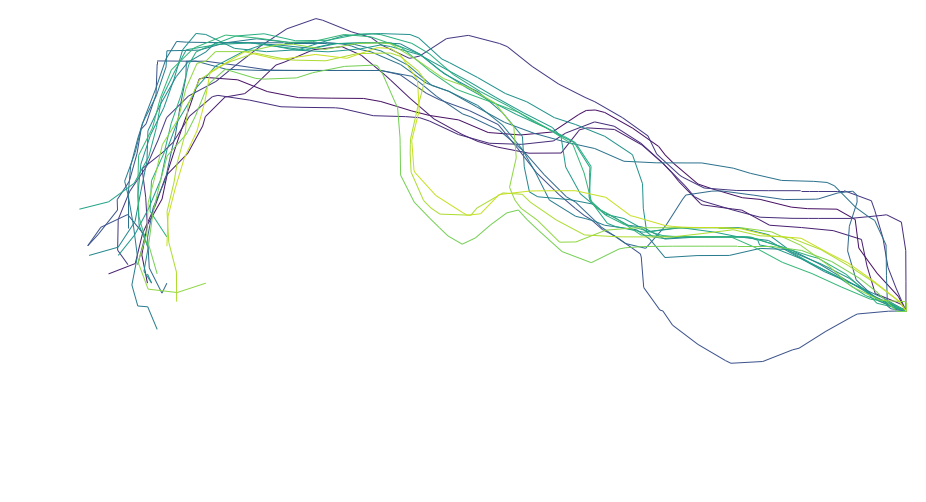

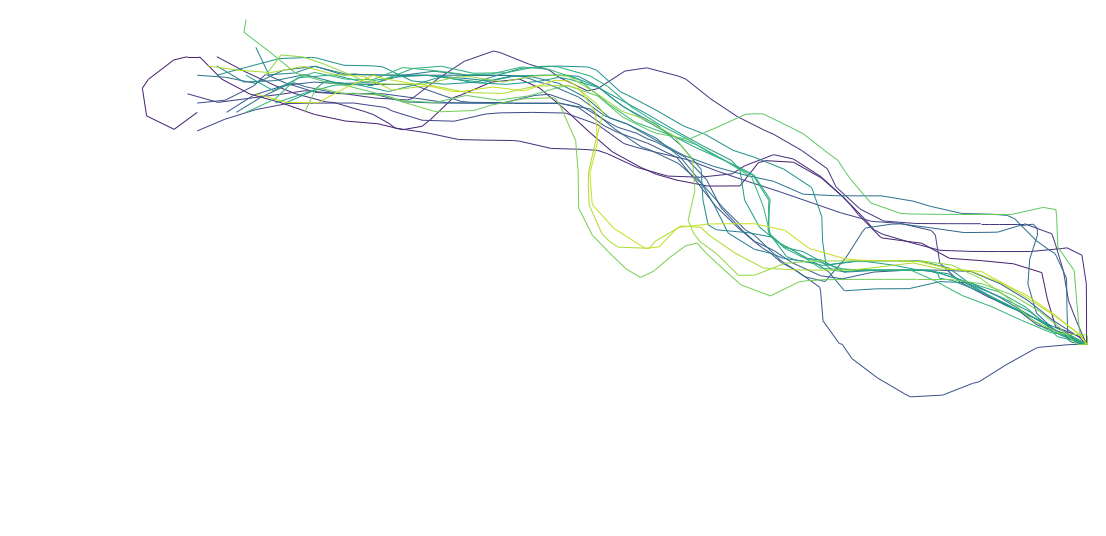

In [488]:

for k in range(len(dis)):
    arounding = centroids[:, dis[k]]
    patch_to_show = []
    for i in range(len(names)):
        neuron = McNeuron.Neuron(soma_adj(np.loadtxt(path+names[i])))
        node_index = get_arounding_node_index(neuron, arounding, radius=radius)
        if len(node_index)>0:
            swc_traj = soma_adj(get_trajectory(neuron, node_index[0]))
            trajectory = McNeuron.Neuron(swc_traj)
            patch_info = neuron_patches(trajectory, color=c[i, :], 
                                        node_index_red_after=swc_traj.shape[0]-1, line_width_scale=1)
            patch_to_show.append(patch_info)
    lines, linewidths, colors, max_x, max_y, min_x, min_y = add_patches(patch_to_show)
    show_patches(lines, linewidths, colors, max_x, max_y, min_x-30, min_y-50, alpha=1, image_scale=3)

In [450]:
trajs = []
for i in range(len(names)):
    neuron = McNeuron.Neuron(soma_adj(np.loadtxt(path+names[i])))
    node_index = get_arounding_node_index(neuron, arounding, radius=radius)
    if len(node_index)>0:
        swc_traj = soma_adj(get_trajectory(neuron, node_index[0]))
        trajectory = McNeuron.Neuron(swc_traj)
        # plt.scatter(trajectory.location[0,:], trajectory.location[1,:],color=c[i, :])
        trajs.append(trajectory.location)
#         patch_info = neuron_patches(trajectory, color=c[i, :], 
#                                     node_index_red_after=swc_traj.shape[0]-1, line_width_scale=1)

In [449]:
from scipy.spatial.distance import directed_hausdorff
u = np.array([(1.0, 0.0),
              (0.0, 1.0),
              (-1.0, 0.0),
              (0.0, -1.0)])
v = np.array([(2.0, 0.0),
              (0.0, 2.0),
              (-2.0, 0.0),
              (0.0, -4.0)])
directed_hausdorff(u, v)[0]

(2.23606797749979, 3, 0)

In [460]:
len(trajs)

22

In [454]:
A = np.zeros([len(names), len(names)])
for i in range(len(names)):
    for j in range(i, len(names)):
        A[i, j] = directed_hausdorff(trajs[i], trajs[j])[0]

In [459]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(A, 'ward')